In [1]:
#using DifferentialEquations



In [1]:
using Plots

In [2]:
### Object declaration
mutable struct Particle
    # Position
    x::Float64
    y::Float64
    # Velocity
    v_x::Float64
    v_y::Float64
    # Other properties: mass, charge
    m::Float64
    q::Float64
    
    # Constructors
    Particle(x, y, v_x, v_y, m, q) = new(x, y, v_x, v_y, m, q)
    Particle(x, y, v_x, v_y) = new(x, y, v_x, v_y, 1, 0)
    
end

function phase_trajectories(p::Particle)
    return (p.x, p.y, p.v_x, p.v_y)
end
#particles = [Particle(i, 2*i, i, i, i, i) for i in 1:3]

phase_trajectories (generic function with 1 method)

In [229]:
K = -10
x = 2.
y = 1.5
#p1 = Particle(0.0, 0.0, 0.0, 1.0)
#p2 = Particle(1, 0.8, 0.5, 0.5)
#particles = [p1, p2]

t_span = (0.0,3.0)
#N_steps = 1000


#function foo(p::Particle)
#    [p.v_x, p.v_y,  K / p.m * (p.x - x) / ((p.x - x)^2 + (p.y - y)^2)^3,K / p.m * (p.y - y) / ((p.x - x)^2 + (p.y - y)^2)^3]
#end
#function foo(u,p,t) 
#    return  [u[3], 
#            u[4],  
#            K * (u[1] - u[5]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            K * (u[2] - u[6]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            u[7],
#            u[8],
#            K * (u[5] - u[1]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            K * (u[6] - u[2]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3]
#            
#end

#function RK4(u, f::Function, dt)
#    k1 = f()
#end

function Forces(p::Particle, dt)
    x = 0.0
    y = 0.0
    (a1, a2) =  [p.x-x, p.y-y] * K/(sqrt((p.x-x)^2 + (p.y-y)^2)^3)
    (p.v_x, p.v_y) = [p.v_x, p.v_y] + dt * [a1, a2]
    (p.x, p.y) = [p.x, p.y] + [p.v_x, p.v_y] + dt * [a1, a2]/2) * dt^2
end

function trajectory(p::Particle, t_range::Tuple, N)
    dt = (t_range[2]-t_range[1])/N
    trajectory = zeros(N+1, 4)
    trajectory[1,:] = [p.x, p.y, p.v_x, p.v_y]
    
    for i in 2:(N+1)
        Forces(p, dt)
        trajectory[i,:] = [p.x, p.y, p.v_x, p.v_y]
    end
    
    return trajectory
end

#phase_trajectories(p1)

#u[:,1] = [p.x,p.y,p.v_x,p.v_y]
#u_0 = Float64[i for j in particles for i in phase_trajectories(j)]
#prob = ODEProblem(foo, u_0, t_span)

#sol = solve(prob)
#plot(sol)

#foo([1,2,1,33], 0, 0)

LoadError: syntax: extra token ")" after end of expression

In [107]:
sol = trajectory(Particle(1,1,1,0,1,0), (0,1), 100)

LoadError: UndefVarError: trajectory not defined

In [594]:
### Proportionality constant
κ = 4
### Particle cross section radius
σ = 0.1
### Restitution coefficient
ρ = 1

function Forces(particles, i, dt)
    position = zeros(4)
    p = particles[i]

    position[3:4] .= [p.v_x, p.v_y]
    position[1:2] .= [p.x, p.y]
    for (index, p_other) in enumerate(particles)         
        if(index != i)   
            (a1, a2) = [p.x-p_other.x, p.y-p_other.y] * p.q*p_other.q*κ/p.m /
                       (sqrt((p.x-p_other.x)^2 + (p.y-p_other.y)^2)^3)
            
            position[3:4] .= position[3:4] + dt * [a1, a2]
            position[1:2] .= position[1:2] + [p.v_x, p.v_y]*dt + [a1, a2]/2 * dt^2
            
        end
        
    end
    return position
end

function Trajectories(particles, t_range::Tuple, N)
    dt = (t_range[2] - t_range[1])/N
    trajectories = zeros(N + 1, 4 * length(particles))
    for (index, p) in enumerate(particles)
        trajectories[1, (4*index-3):(4*index)] .= [p.x, p.y, p.v_x, p.v_y]
    end

    for i in 2:(N + 1)
        #for (index, p) in enumerate(particles)
        #    Collisions(particles, index, dt)
        #end
        
        for (index, p) in enumerate(particles)   
            Collisions(particles, index, dt)
            trajectories[i,(4*index-3):(4*index)] .= Forces(particles, index, dt)             
        end
        
        # Save positions
        for (index, p) in enumerate(particles)   
            (p.x, p.y, p.v_x, p.v_y) = trajectories[i, (4*index-3):(4*index)]            
            #Collisions(particles, index)
        end
        
        

    end
    
    return trajectories
end

function Collisions(particles, i)
    p = particles[i]
    for (index, p_other) in enumerate(particles)
        if (index != i)
            if(isCollision(p, p_other))
                println("true")
                Direction!(p, p_other)
            end
        end
    end
end

function Collisions(particles, i, dt)
    p = particles[i]
    for (index, p_other) in enumerate(particles)
        if (index != i)
            if(isCollision(p, p_other, dt))
                #println("true")
                Direction!(p, p_other)
            end
        end
    end
end


    
function isCollision(p1, p2)
    (p1.x-p2.x)^2 + (p1.y-p2.y)^2 < σ^2 ? true : false
end

function isCollision(p1, p2, dt)
    (p1.x+p1.v_x*dt-p2.x-p2.v_x*dt)^2 + (p1.y+p1.v_y*dt-p2.y-p2.v_y*dt)^2 < σ^2 ? true : false
end


function Direction!(p1, p2)
    μ = p1.m + p2.m
    v_x = (p1.m * p1.v_x + p2.m * p2.v_x) / μ
    v_y = (p1.m * p1.v_y + p2.m * p2.v_y) / μ
    p12v = [
        v_x - p2.m * ρ * (p1.v_x - p2.v_x) / μ,
        v_y - p2.m * ρ * (p1.v_y - p2.v_y) / μ,
        v_x + p1.m * ρ * (p1.v_x - p2.v_x) / μ,
        v_y + p1.m * ρ * (p1.v_y - p2.v_y) / μ
    ]
    (p1.v_x, p1.v_y, p2.v_x, p2.v_y) = p12v
    #(p1.v_x, p1.v_y) = p12v
    
end

Direction! (generic function with 1 method)

In [590]:
p1 = Particle(0,1,1,-1, 1, 1)
p2 = Particle(3,1,-0.5,-1, 1, -1)
#p3 = Particle(0,0.09,-1,0)
#p4 = Particle(-1,0,1,0)
#p5 = Particle(-0.5,0.5,0,-1)
particles = [p1, p2] #, p3, p4,p5]
#particles = [p3, p4, p5]

2-element Array{Particle,1}:
 Particle(0.0, 1.0, 1.0, -1.0, 1.0, 1.0)
 Particle(3.0, 1.0, -0.5, -1.0, 1.0, -1.0)

In [591]:
sol = Trajectories(particles, (0,2), 1000)

true
true
true
true
true
true
true
true


1001×8 Array{Float64,2}:
 0.0          1.0     1.0        -1.0  3.0       1.0    -0.5       -1.0
 0.00200089   0.998   1.00089    -1.0  2.999     0.998  -0.500889  -1.0
 0.00400356   0.996   1.00178    -1.0  2.998     0.996  -0.50178   -1.0
 0.00600801   0.994   1.00267    -1.0  2.99699   0.994  -0.502672  -1.0
 0.00801425   0.992   1.00357    -1.0  2.99599   0.992  -0.503566  -1.0
 0.0100223    0.99    1.00446    -1.0  2.99498   0.99   -0.504462  -1.0
 0.0120321    0.988   1.00536    -1.0  2.99397   0.988  -0.50536   -1.0
 0.0140437    0.986   1.00626    -1.0  2.99296   0.986  -0.50626   -1.0
 0.0160571    0.984   1.00716    -1.0  2.99194   0.984  -0.507161  -1.0
 0.0180724    0.982   1.00806    -1.0  2.99093   0.982  -0.508065  -1.0
 0.0200894    0.98    1.00897    -1.0  2.98991   0.98   -0.50897   -1.0
 0.0221082    0.978   1.00988    -1.0  2.98889   0.978  -0.509877  -1.0
 0.0241289    0.976   1.01079    -1.0  2.98787   0.976  -0.510786  -1.0
 ⋮                                     

In [592]:
p1
#p2

Particle(1.9296680061412617, -1.0000000000000016, 0.3868666723338832, -1.0, 1.0, 1.0)

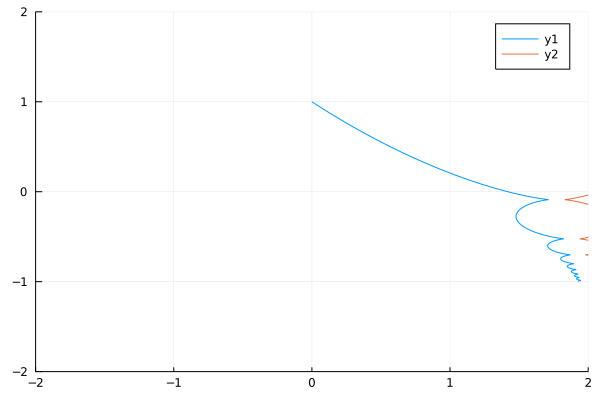

In [593]:

plot(sol[:,1], sol[:,2], lims=(-2,2))
for (index, p) in enumerate(particles)
    if index == 1
        continue
    end
    plot!(sol[:,(4*index-3)], sol[:,(4*index-2)])
end
current()
